<a href="https://colab.research.google.com/github/SoniaVG/Reinforcement-Learning-IA/blob/main/Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Reinforcement Learning beginner to master - AI in Python**
>## **Actor crítico de ventaja**

Es combinación de los métodos:

>**POLICY GRADIENT +  TEMPORAL DIFFERENCE**

Trabaja con dos redes neuronales en el proceso de entrenamiento: actor y critico. La red actor, se encarga de tomar acciones y mientra que la red crítico, se encarga de calificar a estas acciones tomadas. Y el aprendizaje se ambas redes se basa en una función de recompeza (que es para maximizar la recompenza).

Basado en una función de valor y una politica. La función de valor $V_\pi$ se busca a través de la exploración, califica la mejor acción dado un estado. La politica $\pi$ devuelve una acción.

EL crítico es generado por medio de la función de ventaja $Adv$, la cual busca las "mejores criticas"(aquellas que maximizan la recompesa) a las acciones basandose enacciones pasadas.

>**FUNCIÓN DE VENTAJA**

Se calcula por el método de diferencia temporal:

$Adv_\pi=q_\pi(a,s)-v_\pi(s)$ o
bien, en otros términos:

>>$Adv(S_{k+1},S_k,r)=r+ \gamma V(S_{k+1})-V(S_k)$

$V(S_k)$ es la función evaluadora antes de tomar la acción y $V(S_{k+1})$ es después de tomat la acción. La función $V$ será la red neuronal conocido como crítico.

* Si $Adv > 0$ tomar la acción es mejor que seguir la politica.

* Si $Adv< 0$ tomar la acción es peor que seguir la politica.

La politica $\pi$ es la red neuronal llamada actor que se encarga de generar las acciones. Su salida es una para cada estados.

Obs:  pueden haber salidas discretas y continuas.

>**FUNCIÓN DE PÉRDIDA**

Ambas redes tienen una función de pérdida asociada a optimmizar.
Para el crítico:
> $Loss_{critic}=1/2 \{Adv(S_{k+1},S_k,r)\}^2+ H$

Para el actor:

>$Loss_{critic}=-\log(\pi) Adv(S_{k+1},S_k,r)+ H$,

donde $H$ es la entropía (que se encarga de que todas o casi todas las acciones sean exploradas, a mayor entropía mejor porque  esto garantiza lo anterior. Debido a esto, se incluye en la pérdida para maximizar).



In [ ]:
from IPython.display import clear_output
!pip install gymnasium
%matplotlib inline
clear_output()
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym
import torch
import torch. nn as nn
from torch.optim import AdamW
import copy
import random
from pickleshare import stat
import torch.nn.functional as F
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

Reset:  [ 0.9984024  -0.05650368  0.99628836 -0.08607858  0.01070488  0.0205308 ]
Discrete(3)
Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)


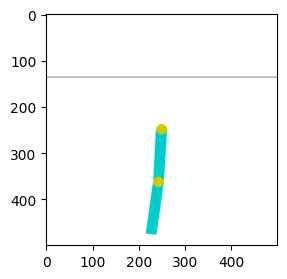

In [ ]:
env=gym.make('Acrobot-v1', render_mode="rgb_array")

print("Reset: ",env.reset()[0])
plt.figure(figsize = (3,3))
plt.imshow(env.render())

print(env.action_space)
print(env.observation_space)

In [ ]:
class PreprosessEnv(gym.Wrapper):
  def __init__(self, env):
    gym.Wrapper.__init__(self, env)

  def reset(self):
    state = self.env.reset()[0]

    # Ajuste para trabar con baches, estados: [[1,2],[0., 1.]], acciones [[2],[0]]
    # i.e. es dar dimensión a los esatdos y a las acciones
    return torch.from_numpy(state).unsqueeze(dim=0).float()


  def step(self,action):
    action = action.item()
    next_state, reward, done, info1,  info2= self.env.step(action)
    #print("next_state", next_state)
    next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
    #print("next_state", next_state)
    reward = torch.tensor(reward).view(1,-1).float()#[[0.]]
    #print("reward",reward)
    done =  torch.tensor(done).view(1,-1)
    return next_state, reward, done, info1, info2

env=gym.make('Acrobot-v1', render_mode="rgb_array")
env =  PreprosessEnv(env)
env.reset()

tensor([[ 0.9977, -0.0675,  0.9969,  0.0793, -0.0680, -0.0281]])

In [ ]:
dims = 6
actions =  3
# ACTOR
policy = nn.Sequential(
    nn.Linear(dims,128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1) #[0,1]
)

#CRÍTICO
value_net = nn.Sequential(
    nn.Linear(dims,128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)# [-inf,inf]
)

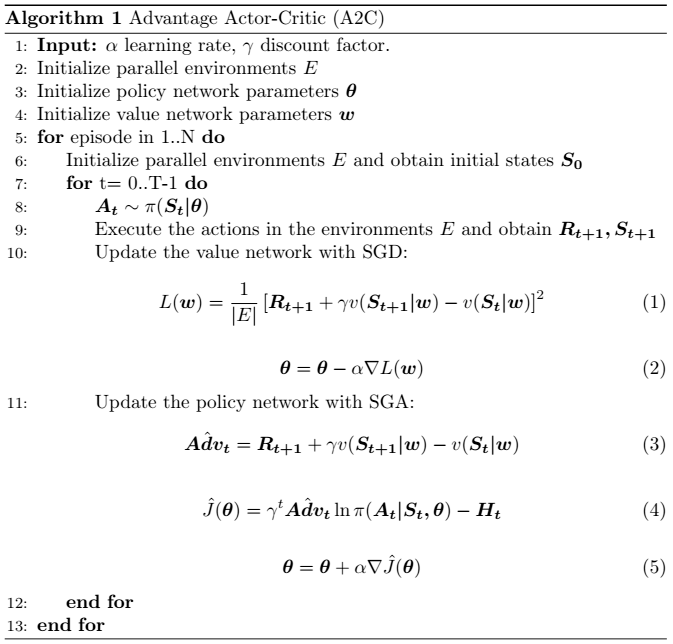

In [ ]:
def actor_critic(policy, value_net, episodes, alpha = 1e-4, gamma = 0.99):
    policy_optim = AdamW(policy.parameters(), lr = alpha)
    value_optim = AdamW(value_net.parameters(), lr = alpha)
    stats = {"actor loss":[], "critic loss": [], "return": []}

    for episode in tqdm(range(episodes + 1)):
        state = env.reset()
        done_b = torch.zeros((1,1), dtype=torch.bool)
        ep_return = torch.zeros((1,1))

        I = 1.0

        while not done_b:
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _, _ = env.step(action)

            value = value_net(state) #V(S)
            target = reward + ~done *  gamma * value_net(next_state).detach()
            critic_loss = F.mse_loss(value, target) #L(w)= valor observado- target

            value_net.zero_grad() #limpiar los gradientes
            critic_loss.backward() #derevada parcial de la función de perdida L(W)
            value_optim.step() #para actualizar los parametros de la red y por tanto, la red

            advantage = (target-value).detach() #adv
            probs = policy(state)
            logs_prob = torch.log(probs + 1e-6 )
            action_log_prob = logs_prob.gather(1, action)
            entropy = -torch.sum(probs * logs_prob, dim=-1, keepdim=True) #H(t)

            actor_loss = -I*action_log_prob * advantage-0.01* entropy #J(theta)
            actor_loss = actor_loss.mean()

            policy.zero_grad()
            actor_loss.backward()
            policy_optim.step()

            ep_return += reward
            done_b = done
            state= next_state
            I = I*gamma ##gamma**t

        stats["actor loss"].append(actor_loss.item())
        stats["critic loss"].append(critic_loss.item())
        stats["return"].append(ep_return.mean().item())
    return stats


env=gym.make('Acrobot-v1', render_mode="rgb_array")
env =  PreprosessEnv(env)

stats = actor_critic(policy, value_net,1200, alpha = 1e-4, gamma = 0.99)

100%|██████████| 1201/1201 [07:31<00:00,  2.66it/s]


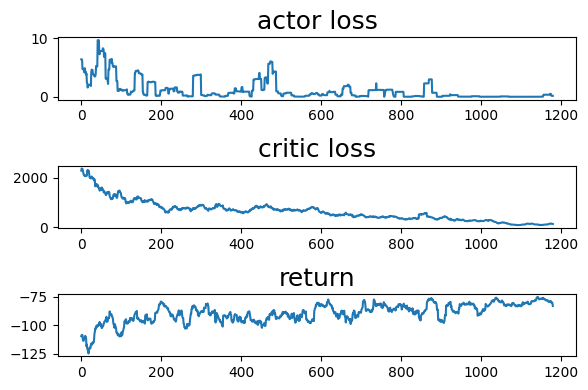

In [ ]:
def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(6, 4))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()

plot_stats(stats)


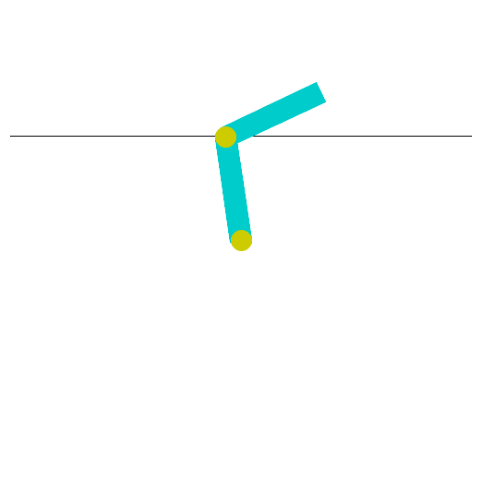

In [ ]:
from IPython.display import display
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline


def test_policy_network(env, policy, episodes=1):
    from IPython import display
    plt.figure(figsize=(6, 6))
    for episode in range(episodes):
        state = env.reset()
        print(state)
        done = False
        img = plt.imshow(env.render())

        while not done:
            #print(torch.from_numpy(np.array(state)))
            #state = torch.from_numpy(np.array(state)).unsqueeze(0).float()
            #print(state)
            action = policy(state).multinomial(1)
            next_state, _, done, _,_= env.step(action)
            img.set_data(env.render())
            plt.axis('off')
            display.display(plt.gcf())
            clear_output(wait=True)
            state = next_state

test_policy_network(env, policy, episodes=2)